# Исследование окупаемости рекламы в приложении.

Несколько прошлых месяцев наш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нам нужно разобраться в причинах этой ситуации.  
У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам нужно изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.
---
\* Исследование проводится на искусственных данных

#### Шаг 1. Загрузим данные и подготовим их к анализу
 
#### Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии

#### Шаг 3. Проведем исследовательский анализ данных
Ответим на вопросы
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?.

#### Шаг 4. Маркетинг
Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

#### Шаг 5. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. Считаем, что в нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 3 недели после привлечения пользователей.

#### Шаг 6.Сделаем выводы
- Выделим причины неэффективности привлечения пользователей;
- Сформируем рекомендации для отдела маркетинга для повышения эффективности.


#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# 1. Предобработка

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

pd.options.display.float_format = '{:,.3f}'.format

In [8]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

# приведение названий столбцов к единому виду
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

# приведение дат к нужному типу и выделение дополнительных временных промежутков
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders['dt'] = orders['event_dt'].dt.date
orders['week'] = orders['event_dt'].dt.isocalendar().week


Итак, имеем сырые данные в таком виде:

In [9]:
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue,dt,week
0,188246423999,2019-05-01 23:09:52,4.990,2019-05-01,18
1,174361394180,2019-05-01 12:24:04,4.990,2019-05-01,18
2,529610067795,2019-05-01 11:34:04,4.990,2019-05-01,18
3,319939546352,2019-05-01 15:34:40,4.990,2019-05-01,18
4,366000285810,2019-05-01 13:59:51,4.990,2019-05-01,18


,dt,channel,costs,week
0,2019-05-01,FaceBoom,113.300,18
1,2019-05-02,FaceBoom,78.100,18
2,2019-05-03,FaceBoom,85.800,18
3,2019-05-04,FaceBoom,136.400,18
4,2019-05-05,FaceBoom,122.100,18


# 2. Спец. функции для расчета и LTV, ROI, удержания и конверсии.

Функции не моего авторства, но отлично подходят для задачи.

In [10]:
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

# 3. Исследовательский анализ данных

Построим профили пользователей. Получим из сырых данных таблицу пользователей **users**, в которой для каждого пользователя получим месяц привлечения, примерную стоимость привлечения и флаг, конвертировался ли он в покупателя.

In [11]:
users = get_profiles(visits, orders, costs)
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
users['dt_week'] = users['first_ts'].dt.isocalendar().week
users.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,dt_week
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088,19
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107,28
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000,40
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988,34
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.231,40


In [12]:
# убираем из анализа органический трафик
users = users[users['channel'] != 'organic']
orders = orders[orders['user_id'].isin(users['user_id'])]

Посмотрим на конверсию пользователей в покупателей по регионам, устройствам и каналам.

,пользователи,покупающие,конверсия
region,,,
United States,61829,6108,0.099
Germany,9528,490,0.051
UK,11154,569,0.051
France,11058,554,0.050


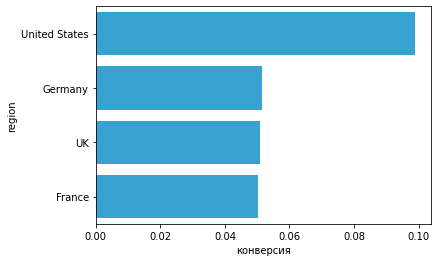

In [13]:
region_stat = users.groupby('region').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
region_stat.columns = ['пользователи', 'покупающие', 'конверсия']
region_stat.sort_values(by='конверсия', inplace=True, ascending=False)
sns.barplot(y = region_stat.index, x = region_stat['конверсия'], color='#1faee9')
region_stat

США лидируют по конверсии с большим отрывом.

,пользователи,покупающие,конверсия
device,,,
Mac,18693,1673,0.089
iPhone,33882,2972,0.088
Android,21841,1782,0.082
PC,19153,1294,0.068


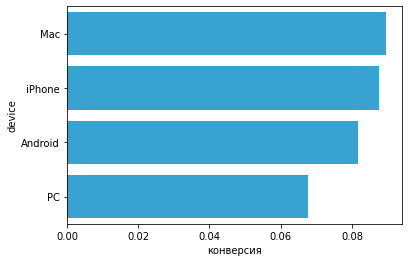

In [14]:
device_stat = users.groupby('device').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
device_stat.columns = ['пользователи', 'покупающие', 'конверсия']
device_stat.sort_values(by='конверсия', inplace=True, ascending=False)
sns.barplot(y = device_stat.index, x = device_stat['конверсия'], color='#1faee9')
device_stat

Лучше всего конвертируются пользователи Apple.

,пользователи,покупающие,конверсия
channel,,,
FaceBoom,29144,3557,0.122
AdNonSense,3880,440,0.113
lambdaMediaAds,2149,225,0.105
TipTop,19561,1878,0.096
RocketSuperAds,4448,352,0.079
WahooNetBanner,8553,453,0.053
YRabbit,4312,165,0.038
MediaTornado,4364,156,0.036
LeapBob,8553,262,0.031


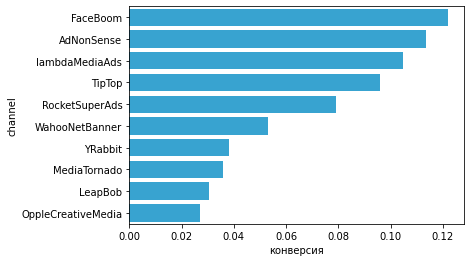

In [15]:
channel_stat = users.groupby('channel').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
channel_stat.columns = ['пользователи', 'покупающие', 'конверсия']
channel_stat.sort_values(by='конверсия', inplace=True, ascending=False)
sns.barplot(y = channel_stat.index, x = channel_stat['конверсия'], color='#1faee9')
channel_stat

Видим широкий спектр показателей конверсии по каналам. Лидируют FaceBoom и AdNonSence, органический трафик ожидаемо конвертируется хуже всего.  
Рассмотрим динамику конверсии за период.

,пользователи,покупающие,конверсия
month,,,
2019-05-01,12416,1004,0.081
2019-06-01,15315,1273,0.083
2019-07-01,14941,1229,0.082
2019-08-01,17545,1435,0.082
2019-09-01,17303,1475,0.085
2019-10-01,16049,1305,0.081


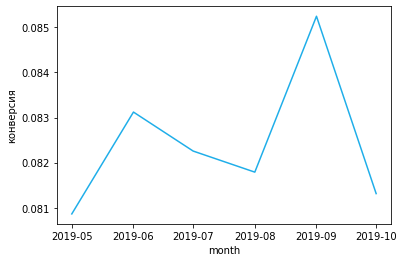

In [16]:
historic_stat = users.groupby('month').agg({'user_id':'nunique', 'payer':['sum', 'mean']})
historic_stat.columns = ['пользователи', 'покупающие', 'конверсия']
sns.lineplot(x = historic_stat.index, y = historic_stat['конверсия'], color='#1faee9')
historic_stat

За исследуемый период общая конверсия колеблется незначительно. Похоже, проблема не в ней.

# 4. Маркетинг

Разберемся с тратами на реламу:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Траты собраны в таблицу:

In [17]:
costs.head()

,dt,channel,costs,week
0,2019-05-01,FaceBoom,113.300,18
1,2019-05-02,FaceBoom,78.100,18
2,2019-05-03,FaceBoom,85.800,18
3,2019-05-04,FaceBoom,136.400,18
4,2019-05-05,FaceBoom,122.100,18


In [18]:
#приведем в порядок даты и моздадим отдельный столбец с месяцем трат
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].dt.month

Изучим суммарные траты по каналам:

In [19]:
costs.groupby('channel').sum().sort_values(by='costs', ascending=False)['costs']

channel
TipTop               54,751.300
FaceBoom             32,445.600
WahooNetBanner        5,151.000
AdNonSense            3,911.250
OppleCreativeMedia    2,151.250
RocketSuperAds        1,833.000
LeapBob               1,797.600
lambdaMediaAds        1,557.600
MediaTornado            954.480
YRabbit                 944.220
Name: costs, dtype: float64

Видим, что каналы с большой конверсией TipTop и FaceBoom также забрали многократно большую часть бюджета. В этом может крыться корень проблемы. Выясним, сколько стоил пользователь в разрезе регионов и устройств.

In [20]:
display(users.groupby('region')['acquisition_cost'].mean().sort_values(ascending=False))
users.groupby('device')['acquisition_cost'].mean().sort_values(ascending=False)

region
United States   1.471
Germany         0.464
France          0.459
UK              0.454
Name: acquisition_cost, dtype: float64

device
iPhone    1.289
Mac       1.289
Android   1.028
PC        0.797
Name: acquisition_cost, dtype: float64

Пользователи из США, хоть хорошо конвертируются, обходятся в 3 раза дороже. Нужно выяснить, отбиваются ли такие траты.

Посмотрим на ROI по каналам:

In [34]:
#считаем среднюю цену привлечения и среднюю прибыль с пользователя по каналам.
costs_per_channel = users.groupby('channel')['acquisition_cost'].mean()
avg_rev_per_channel = orders.merge(users, on='user_id').groupby('channel').sum()['revenue'] /\
                      orders.merge(users, how='outer').groupby('channel')['user_id'].nunique()
#считаем ROI
roi_total = (avg_rev_per_channel / costs_per_channel - 1).sort_values(ascending=False)
roi_total

channel
YRabbit               5.568
RocketSuperAds        5.328
MediaTornado          5.027
lambdaMediaAds        4.741
LeapBob               4.318
OppleCreativeMedia    2.889
WahooNetBanner        2.884
TipTop                0.271
AdNonSense           -0.055
FaceBoom             -0.210
dtype: float64

<AxesSubplot:ylabel='channel'>

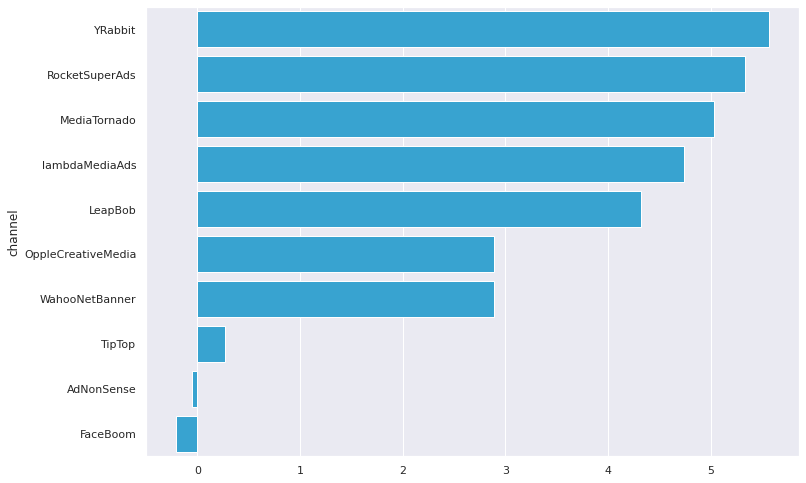

In [30]:
sns.barplot(y = roi_total.index, x = roi_total, color='#1faee9')

TipTop, AdNonSense и FaceBoom, похоже, слишком дорогие. AdNonSense и FaceBoom, вообще не окупаются. TipTop чуть выше уровня окупаемости. Прочие источники показывают хороший ROI от 288% до 556%.

# 5. Оценка окупаемости рекламы в динамике.


Изучим прибыль и траты с течением времени:

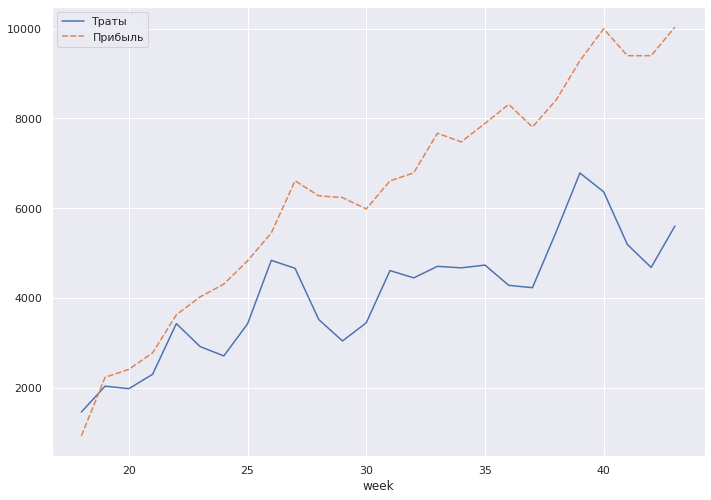

In [22]:
costs_report = costs.groupby('week')['costs'].sum()
rev_by_date = orders.groupby(orders['week'])['revenue'].sum().drop(44) # 44-я неделя не полная
rev_report = pd.concat([costs_report, rev_by_date], axis=1)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=rev_report)
plt.legend(labels=["Траты","Прибыль"])

Видим, что траты стабильно растут, но растет и прибыль. Рассмотрим траты по каналам.

<AxesSubplot:xlabel='dt', ylabel='costs'>

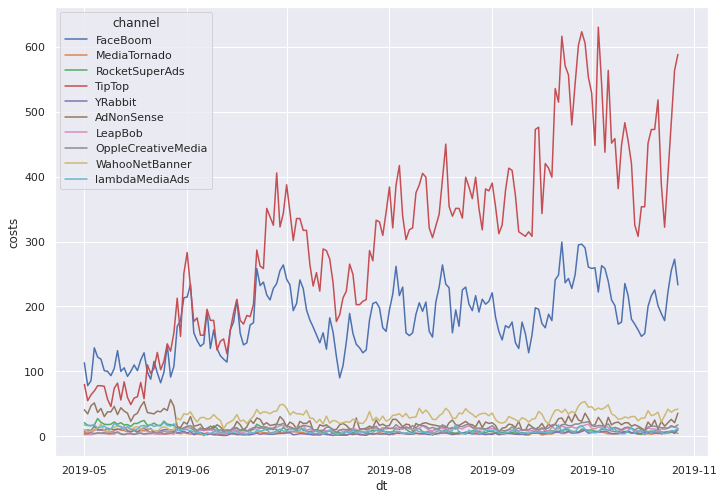

In [23]:
sns.lineplot(data=costs, hue='channel', x='dt', y='costs')

Видим шестикратное увеливчение трат на канал TipTop. Есть ли от канала пропорциональное увеличение прибыли?

<AxesSubplot:xlabel='dt_x', ylabel='revenue'>

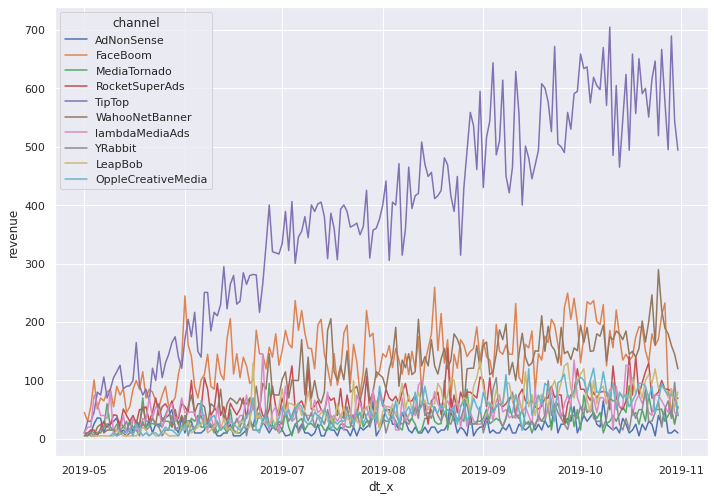

In [24]:
channel_time_series = orders.merge(users, on='user_id', how='left').groupby(['dt_x', 'channel'])['revenue'].sum().reset_index()
sns.lineplot(x = 'dt_x', y='revenue', data=channel_time_series, hue='channel')

Прибыль от TipTop растет пропорционально цене, но вероятно эта прибыль генерируется прошлым, более дешевым трафиком. Нужно внимательно следить за отбиваемостью рекламы от этого источника.

Изучим суммарные траты по регионам:

<AxesSubplot:xlabel='dt', ylabel='acquisition_cost'>

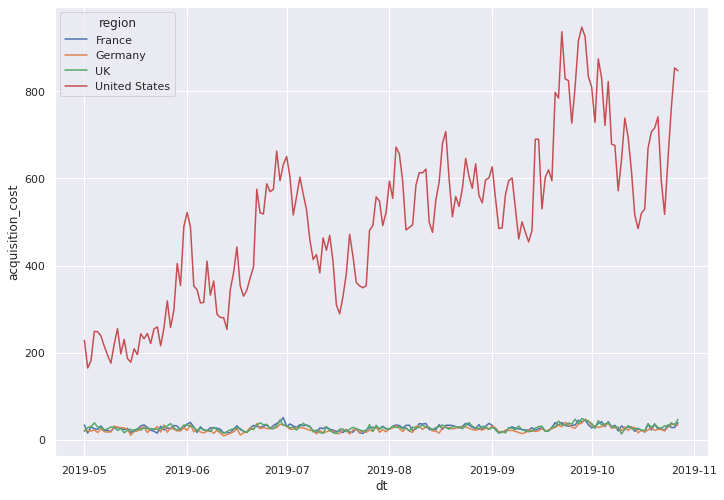

In [25]:
region_time_series = users.groupby(['dt', 'region'])['acquisition_cost'].sum().reset_index()
sns.lineplot(x = 'dt', y='acquisition_cost', data=region_time_series, hue='region')

США потребляет многократно большую часть бюджета, чем другие регионы. Рассмотрим траты по источникам в каждом регионе.

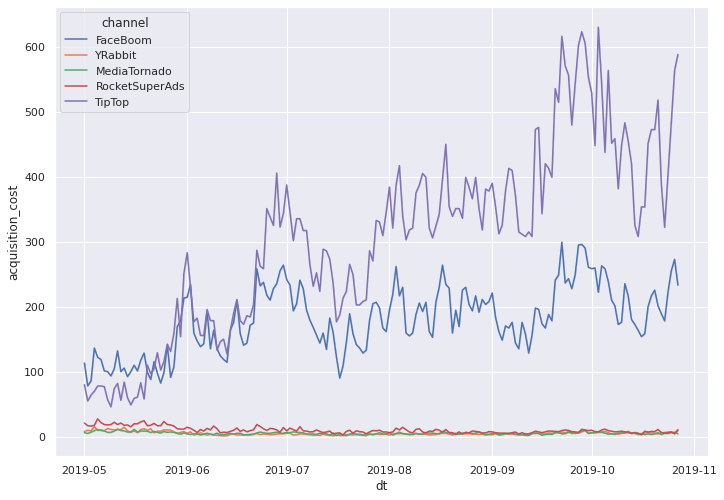

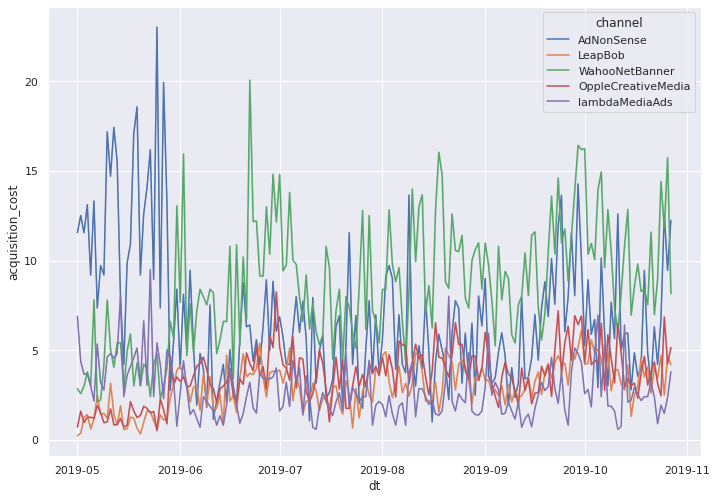

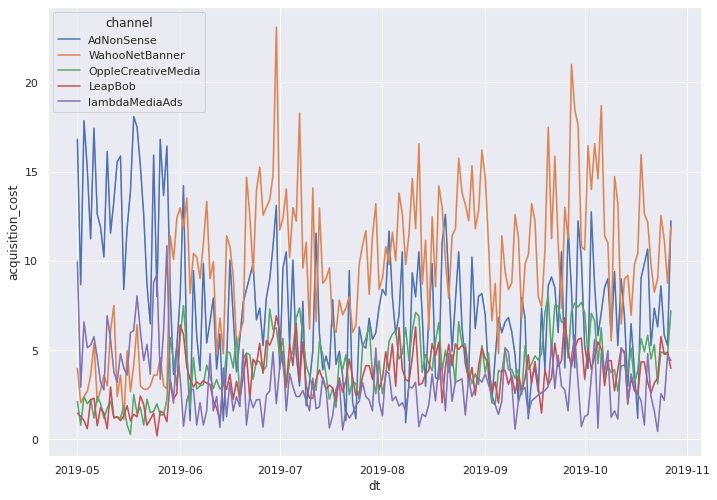

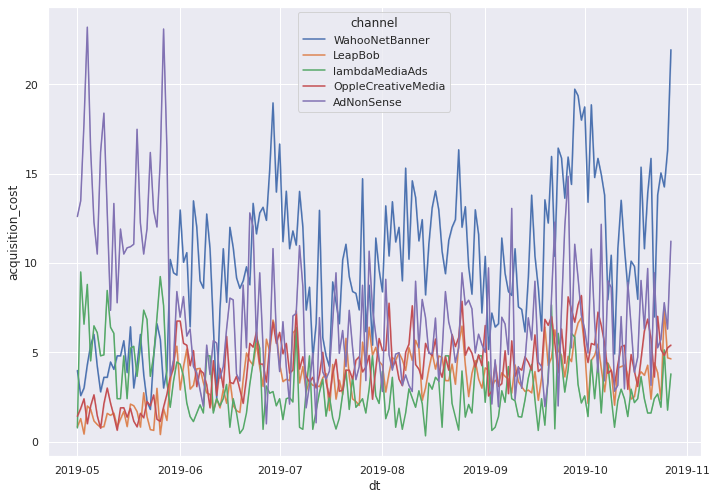

In [26]:
for region in ['United States', 'Germany', 'France', 'UK']:
    region_costs = users[users['region'] == region]
    sns.lineplot(data=region_costs, x='dt', y='acquisition_cost', hue='channel', estimator='sum')
    plt.show()

Видим, что в трёх регионах траты скорее стабильны по всем каналам, но в США они значительными темпами растут для FaceBoom и TipTop - каналов с отрицательной или низкой окупаемостью.

Аналогично изучим стоимость привлечения одного пользователя:

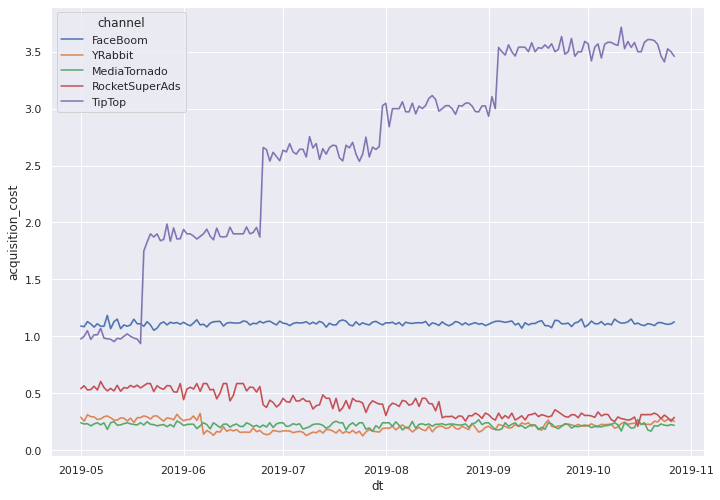

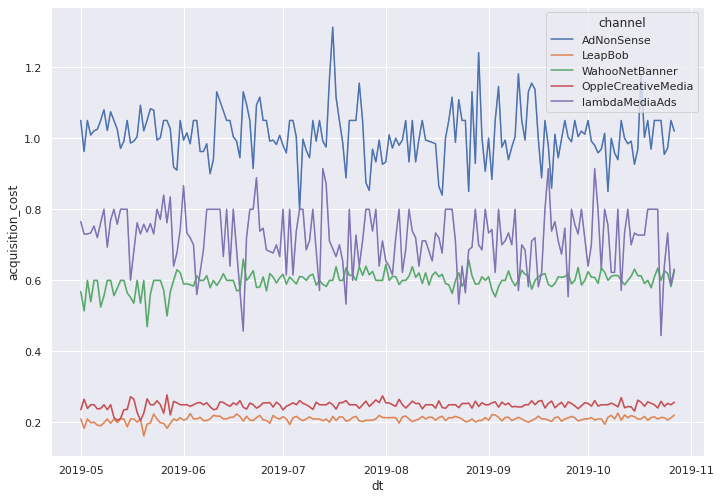

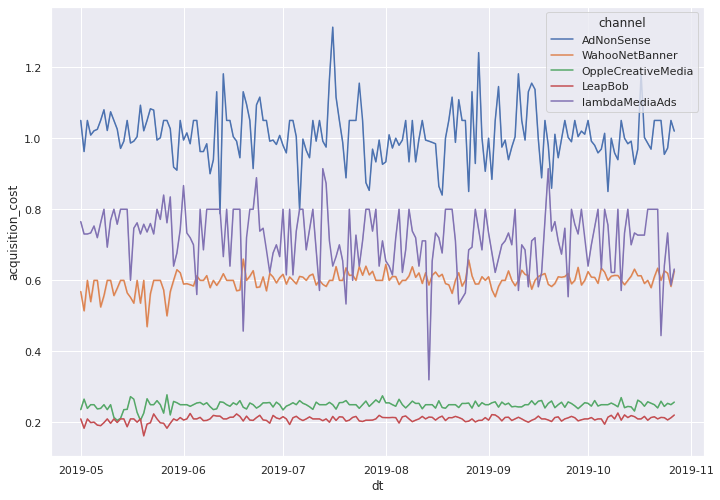

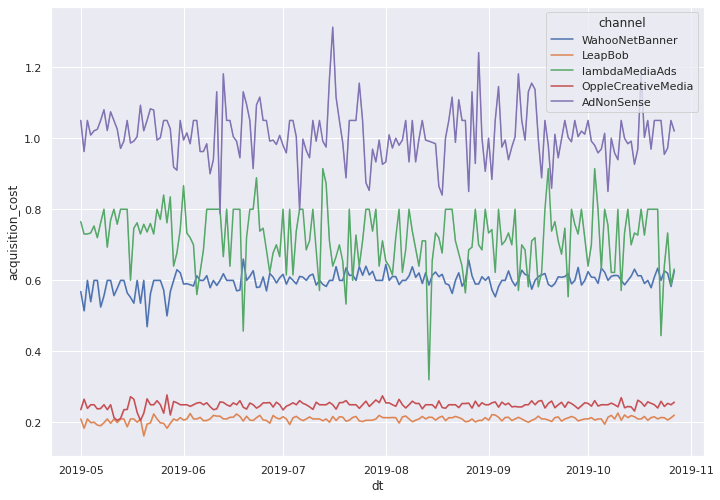

In [27]:
for region in ['United States', 'Germany', 'France', 'UK']:
    region_costs = users[users['region'] == region]
    sns.lineplot(data=region_costs, x='dt', y='acquisition_cost', hue='channel', estimator='mean')
    plt.show()

Видим, что по какой-от причине, тоимость привлечения пользователя из TipTop каждый месяц увеличивается в 1.5 раза. Суммарно она выросла в 3.5 раза за период. Нужно внимательно следить, чтобы при дальнейшем росте цены росла и прибыль, иначе канал может увести маркетинг с минус. 

---

#  6. ROI

In [140]:
(orders['revenue'].sum() / costs['costs'].sum() - 1) * 100

60.51183300425696

Общий ROI кампании 60%, но как быстро отбиваются средства?

Изучим возврат на инвестиции в течение трех недель после привлечения. Посчитаем и и визуализируем ROI

In [62]:
#функция исходя из профилей и заказов считает LTV 
#для указанного промежутка времени с группировкой по нужному полю 
ltv_raw, ltv, ltv_history = get_ltv(
    users, orders, datetime(2022, 5, 13).date(), 50, 
)

In [63]:
ltv_history = ltv_history.drop('cohort_size', axis=1).reset_index()

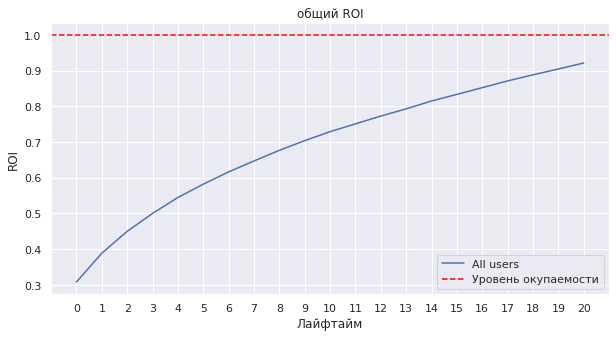

In [143]:
avg_costs_per_user = users['acquisition_cost'].mean()
ltv_raw, ltv, ltv_history = get_ltv(
    users, orders, datetime(2022, 5, 13).date(), 21)
#roi = ltv.div(costs_per_device, axis=0)
roi = ltv/avg_costs_per_user
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('общий ROI')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Видим, что эффективность кампании не соответствует требованиям: мы не выходим на окупаемость на третью неделю lifitime пользователя.

### Окупаемость рекламы с разбивкой по устройствам

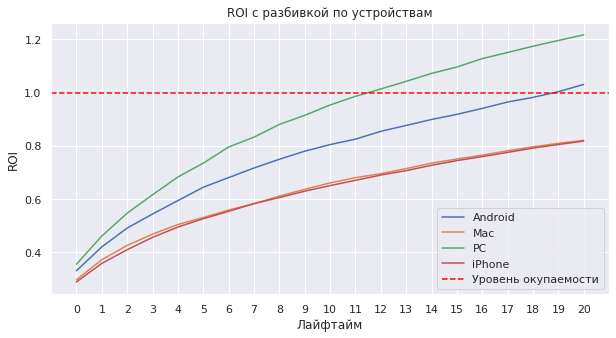

In [157]:
costs_per_device = users[users['channel'] != 'organic'].groupby('device')['acquisition_cost'].mean()
ltv_raw, ltv_device, ltv_history_device = get_ltv(
    users, orders, datetime(2022, 5, 13).date(), 21, dimensions=['device']
)
roi = ltv_device.div(costs_per_device, axis=0)
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по устройствам')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

К концу 3-й недели не отбиваются iPhone и Mac. По всей видимости, это следствие проблем с регионом США, в котором эти устройства преобладают.

### Окупаемость рекламы с разбивкой по регионам

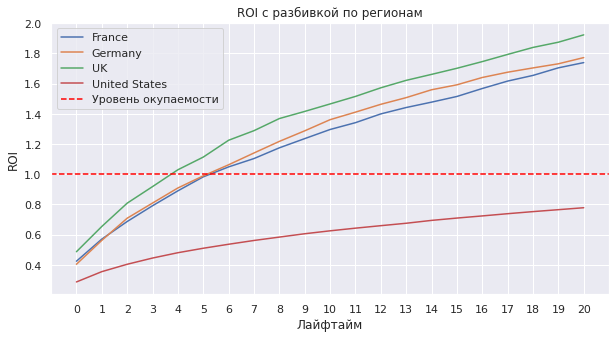

In [147]:
costs_per_region = users.groupby('region')['acquisition_cost'].mean()
ltv_raw, ltv_region, ltv_history_region = get_ltv(
    users, orders, datetime(2022, 5, 13).date(), 21, dimensions=['region']
)
roi = ltv_region.div(costs_per_region, axis=0)
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по регионам')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Действительно, в США дела обстоят не очень - реклама не отбивается. Будем искать причину. Все прочие регионы демонстрируют уверенную окупаемость.

### Окупаемость рекламы с разбивкой по  каналам

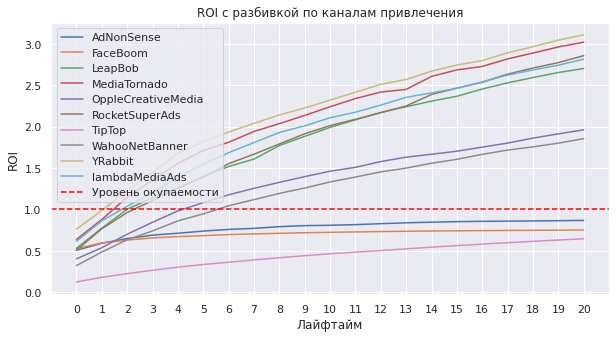

In [148]:
costs_per_channel = users.groupby('channel')['acquisition_cost'].mean()
ltv_raw, ltv_channel, ltv_history_channel = get_ltv(
    users, orders, datetime(2022, 5, 13).date(), 21, dimensions=['channel']
)
roi = ltv_channel.div(costs_per_channel, axis=0)#.drop('organic')
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Три канала не окупаются за 3 недели, два из них эксклюзивны для США. Похоже, именно из-за них страдает регион. TipTop вообще забирает бОльшую часть бюджета. Как показано выше, в итоге он отбивается и показывает ROI 27%, но это занимает более двух месяцев и скорее всего только благодаря  низким ценам в перыве месяцы. У нас пока нет данных, что будет с учетом недавнего порвышения цен. В связи с этим можно порекомендовать уменьшить бюджет и внимательно следить за эффективностью в ближайшие месяцы.

## Удержание.

Text(0.5, 1.0, 'Удержание платящих пользователей по устройствам')

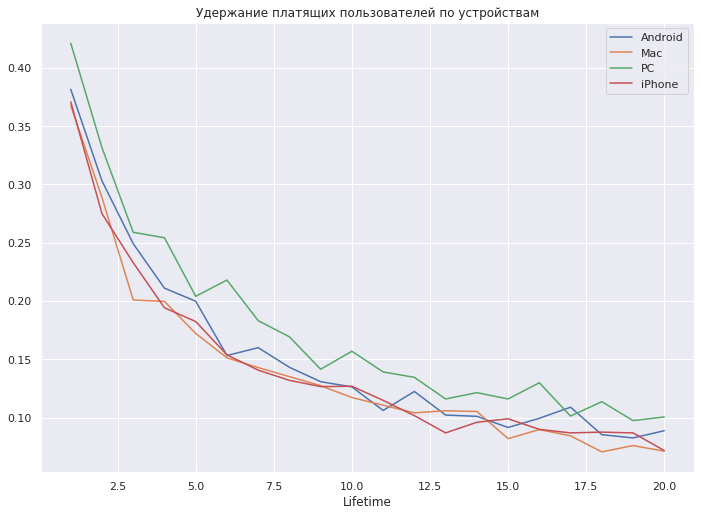

In [150]:
ret_raw, retention, retention_history = get_retention(users, visits,  datetime(2022, 5, 13).date(), 21, dimensions=['device'])

# удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
retention = retention.drop(columns = ['cohort_size', 0]) 
retention.query('payer == True').droplevel('payer').T.plot(grid = True)
plt.legend()
plt.xlabel('Lifetime')
plt.title('Удержание платящих пользователей по устройствам')

По устройствам ощутимой разницы в удержании нет.

Text(0.5, 1.0, 'Удержание платящих пользователей по устройствам')

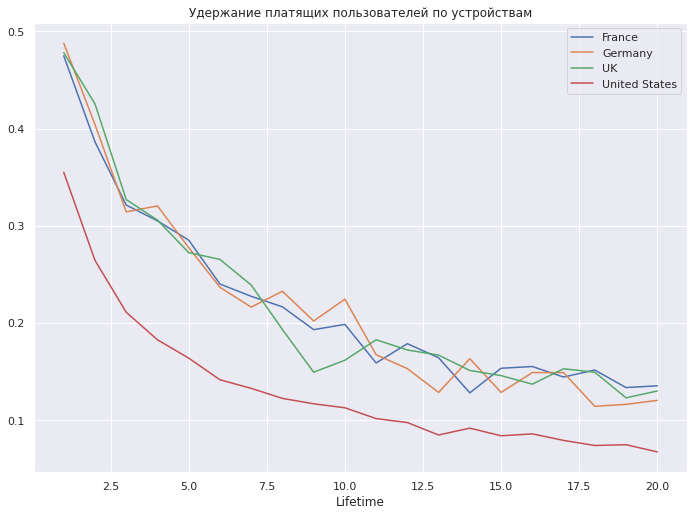

In [151]:
ret_raw, retention, retention_history = get_retention(users, visits,  datetime(2022, 5, 13).date(), 21, dimensions=['region'])

# удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
retention = retention.drop(columns = ['cohort_size', 0]) 
retention.query('payer == True').droplevel('payer').T.plot(grid = True)
plt.legend()
plt.xlabel('Lifetime')
plt.title('Удержание платящих пользователей по устройствам')

В США удержание на порядок ниже, рассмотрим этот регион в разрезе каналов.

Text(0.5, 1.0, 'Удержание платящих пользователей по устройствам')

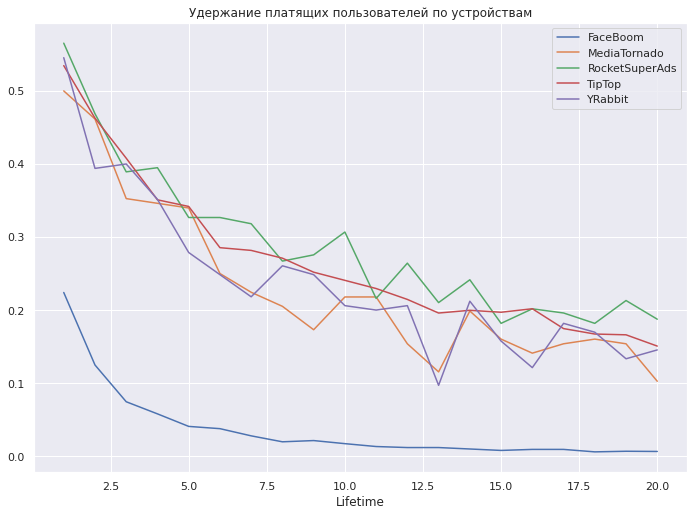

In [152]:
us_users = users.query('region == "United States"')
ret_raw, retention, retention_history = get_retention(us_users, visits,  datetime(2022, 5, 13).date(), 21, dimensions=['channel'])

# удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
retention = retention.drop(columns = ['cohort_size', 0]) 
retention.query('payer == True').droplevel('payer').T.plot(grid = True)
plt.legend()
plt.xlabel('Lifetime')
plt.title('Удержание платящих пользователей по устройствам')

Налицо основная проблема - удержание пользователей FaceBoom на очень низком уровне. К концу третьей недели практически сходит на ноль. На этот источник трафика тоже стоит обратить пристальное внимание.

# 6. Выводы
 - Причины неэффективности привлечения пользователей  
 
 В результате исследования выяснилось, что в регионе США есть проблемы с привлечением и удержанием пользователей по некоторым каналам привлечения.
  - Канал Tiptop поднял стоимость привлеченияодного пользователя в 3.5 раза, при этом общий ROI по каналу всего 27%, с учетом низкой стоимости клиена в начале. Скорее всего более дорогие клиенты, привлеченные в последние месяцы не окупятся. Канал окупается долго, пока точных данных нет. 
   - Канал FaceBoom показывает отрицательный ROI. Основная причина - крайне низкое ужержание пользователей.
    - В Европейском регионе отрицательный ROI показывает только канал AdNonecense. На него тратится незначительная часть бюджета и приоритет мер может быть ниже.

 
- Рекомендации для отдела маркетинга для повышения эффективности.
 - Отказаться от трафика из канала FaceBoom в США. Он не приносит прибыли и обладает практически нулевым удержанием пользователей.
 - Пересмотреть политику привлечения трафика через Tiptop. Прежде всего, попробовать снизить цены до прежних уровней (в 2-3 раза ниже). Во вторую очередь, значительно уменьшить объем закупок. С текущим объемом и ценой скорее всего кампания принесет значительные убытки. Через 2-3 месяца, при текущих ценах и уменьенном объеме можно будет сказать, отбиваются ли увеличинные траты.
 - Отказаться от источника AdNonecense в Европейском регионе.
 - Перенаправить бюджет в любые другие каналы. Они все показывают стабильное отбитие расходов на 3-6 день после привлечения пользователя.